# Install required packages

In [1]:
!pip install tsv matplotlib spacy spacy-langdetect pandas

# Download and read archives

In [2]:
base = 'http://www.cim.mcgill.ca/~dudek/206/Logs/AOL-user-ct-collection/'

files = [
    'user-ct-test-collection-02.txt.gz'
]

urls = [
    f'{base}{file}'
    for file in files
]

## Read directly from archives

In [3]:
import os
import io
import pandas as pd
import tsv
import gzip
import urllib
import itertools
import functools
from collections import Counter

def url_to_file(url, filename):
    name, _ = urllib.request.urlretrieve(url, filename)
    return open(name, 'rb')

def download_and_save(url):
    file = url.split('/')[-1]
    if file in os.listdir():
        return open(file, 'rb')
    else:
        return url_to_file(url, file)


def getTextStream():    
    gzFileStreams = map(
        lambda url: download_and_save(url),
        urls)

    textFileStreams = map(
        lambda gzFileStream:
            io.TextIOWrapper(
                gzip.GzipFile(fileobj=gzFileStream, mode='r')),
        gzFileStreams)

    commonTextStream = itertools.chain(*textFileStreams)

    tsvFileStream = iter(
        tsv.TsvReader(commonTextStream))

    return tsvFileStream

## Remove non-english queries

In [4]:
import spacy
from spacy_langdetect import LanguageDetector
# !python -m spacy download en_core_web_md

nlp = spacy.load("en_core_web_md")
nlp.add_pipe(LanguageDetector(), 'languagedetector')

data = []
counter = 0
for row in getTextStream():
    if counter == 1000:
        break
    the_row = list(row)
    if nlp(the_row[1])._.language['language'] == 'en':
        data.append(the_row)
        counter = counter + 1

## Data overview

In [5]:
df = pd.DataFrame(data, columns=['anonID', 'Query', 'QueryTime', 'ItemRank', 'ClickURL'])[1:]
df

,anonID,Query,QueryTime,ItemRank,ClickURL
1,479,family guy movie references,2006-03-03 22:37:46,1,http://www.familyguyfiles.com
2,479,top grossing movies of all time,2006-03-03 22:42:42,1,http://movieweb.com
3,479,top grossing movies of all time,2006-03-03 22:42:42,2,http://www.imdb.com
4,479,car window decals,2006-03-03 23:24:05,9,http://www.customautotrim.com
5,479,car window sponsor decals,2006-03-03 23:27:17,3,http://www.streetglo.net
...,...,...,...,...,...
995,5179,staph infection in heart,2006-03-28 00:51:03,71,http://www.aedhelp.com
996,5179,minocinsideeffects,2006-03-28 00:53:54,None,None
997,5179,knitting instructions,2006-03-28 15:45:02,1,http://www.learntoknit.com
998,5179,time bestbuys,2006-03-30 22:52:13,None,None


### Average query length in characters

In [6]:
queryCounts = Counter(map(
        lambda row: row[1],
        data
))

pd.DataFrame(queryCounts.items(), columns=['query', 'occurences'])

,query,occurences
0,family guy,1
1,family guy movie references,1
2,top grossing movies of all time,2
3,car window decals,1
4,car window sponsor decals,1
...,...,...
436,heartstaphinfection,1
437,minocinsideeffects,1
438,knitting instructions,1
439,time bestbuys,1


In [7]:
def avg(lst):
    return functools.reduce(lambda a,b: a + b, lst) / len(lst)

print('Average query length in characters:')
avg(list(map(lambda i: len(i[1]), data)))

Average query length in characters:


24.225

### Histogram of different queries

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
plt.bar(*zip(*queryCounts.most_common(40)), width=.4)
plt.xticks(rotation=90)
plt.show()

<Figure size 1500x400 with 1 Axes>

### Queries per user

In [9]:
queryPerUserCounts = Counter(map(
        lambda row: row[0],
        data
))

print('Average number of queries per user:')
pd.DataFrame(queryPerUserCounts.items())[1].mean()

Average number of queries per user:


83.33333333333333

# Tokenize and normalize queries

In [10]:
tokenizer = nlp.Defaults.create_tokenizer(nlp)

In [11]:
def tokenize_and_normalize(data):
    tokenized_data = []
    lemmatized = []
    
    for doc in nlp.pipe(data, batch_size=6000, n_threads=2, disable=['tagger']):
        tmp = []
        tmp_lem = []
        for token in doc:
            if not token.is_stop:
                tmp.append(token.text)
                tmp_lem.append(token.lemma_)
        tokenized_data.append(tmp)
        lemmatized.append(tmp_lem)
    return tokenized_data, lemmatized, [' '.join(lemm) for lemm in lemmatized]

df['tokenized'],df['lemmatized'],df['lemmatized_query'] = tokenize_and_normalize(df['Query'])
df

,anonID,Query,QueryTime,ItemRank,ClickURL,tokenized,lemmatized,lemmatized_query
1,479,family guy movie references,2006-03-03 22:37:46,1,http://www.familyguyfiles.com,"[family, guy, movie, references]","[family, guy, movie, reference]",family guy movie reference
2,479,top grossing movies of all time,2006-03-03 22:42:42,1,http://movieweb.com,"[grossing, movies, time]","[gross, movie, time]",gross movie time
3,479,top grossing movies of all time,2006-03-03 22:42:42,2,http://www.imdb.com,"[grossing, movies, time]","[gross, movie, time]",gross movie time
4,479,car window decals,2006-03-03 23:24:05,9,http://www.customautotrim.com,"[car, window, decals]","[car, window, decal]",car window decal
5,479,car window sponsor decals,2006-03-03 23:27:17,3,http://www.streetglo.net,"[car, window, sponsor, decals]","[car, window, sponsor, decal]",car window sponsor decal
...,...,...,...,...,...,...,...,...
995,5179,staph infection in heart,2006-03-28 00:51:03,71,http://www.aedhelp.com,"[staph, infection, heart]","[staph, infection, heart]",staph infection heart
996,5179,minocinsideeffects,2006-03-28 00:53:54,None,None,[minocinsideeffects],[minocinsideeffects],minocinsideeffects
997,5179,knitting instructions,2006-03-28 15:45:02,1,http://www.learntoknit.com,"[knitting, instructions]","[knit, instruction]",knit instruction
998,5179,time bestbuys,2006-03-30 22:52:13,None,None,"[time, bestbuys]","[time, bestbuys]",time bestbuys


In [12]:
from collections import defaultdict

def create_dictionary(data):
    da = defaultdict(set)
    
    for doc in nlp.pipe(data, batch_size=6000, n_threads=2, disable=['ner']):
        for token in doc:
            try:
                da[token.text].add(doc.text)
            except KeyError:
                da[token.text] = {doc.text}
    return da

da = create_dictionary(df['lemmatized_query'])
daaa = create_dictionary(df['Query'])

# def create_token_dictionaries(data):
#     da = defaultdict(set)
    
#     for doc in nlp.pipe(data, batch_size=6000, n_threads=2, disable=['ner']):
#         for token in doc:
#             try:
#                 da[token.text].add(doc.text)
#             except KeyError:
#                 da[token.text] = {doc.text}
#     return da

# daaa = create_token_dictionaries(df['Query'])

# Find similar queries

In [13]:
sims_all = []
for doc in nlp.pipe(df['lemmatized_query'], batch_size=2000, n_threads=4, disable=['ner', 'tagger']):
    sims = []
    for token in doc:
        for similar in tokenizer.pipe(da[token.text]):
            if similar.text != doc.text:
                if similar.text not in sims:
                    sims.append((similar.text, similar.similarity(doc)))
    sims.sort(key=lambda item: item[1] ,reverse=True)
    sims_all.append(sims[:5])
df['similar queries lemmatized'] = sims_all
df

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  


,anonID,Query,QueryTime,ItemRank,ClickURL,tokenized,lemmatized,lemmatized_query,similar queries lemmatized
1,479,family guy movie references,2006-03-03 22:37:46,1,http://www.familyguyfiles.com,"[family, guy, movie, references]","[family, guy, movie, reference]",family guy movie reference,"[(gross movie time, 0.7595110005554876), (fami..."
2,479,top grossing movies of all time,2006-03-03 22:42:42,1,http://movieweb.com,"[grossing, movies, time]","[gross, movie, time]",gross movie time,"[(family guy movie reference, 0.75951100055548..."
3,479,top grossing movies of all time,2006-03-03 22:42:42,2,http://www.imdb.com,"[grossing, movies, time]","[gross, movie, time]",gross movie time,"[(family guy movie reference, 0.75951100055548..."
4,479,car window decals,2006-03-03 23:24:05,9,http://www.customautotrim.com,"[car, window, decals]","[car, window, decal]",car window decal,"[(car window sponsor decal, 0.9475725029393284..."
5,479,car window sponsor decals,2006-03-03 23:27:17,3,http://www.streetglo.net,"[car, window, sponsor, decals]","[car, window, sponsor, decal]",car window sponsor decal,"[(car window decal, 0.9475725029393284), (car ..."
...,...,...,...,...,...,...,...,...,...
995,5179,staph infection in heart,2006-03-28 00:51:03,71,http://www.aedhelp.com,"[staph, infection, heart]","[staph, infection, heart]",staph infection heart,"[(infection, 0.9209831138143527), (assess infe..."
996,5179,minocinsideeffects,2006-03-28 00:53:54,None,None,[minocinsideeffects],[minocinsideeffects],minocinsideeffects,[]
997,5179,knitting instructions,2006-03-28 15:45:02,1,http://www.learntoknit.com,"[knitting, instructions]","[knit, instruction]",knit instruction,[]
998,5179,time bestbuys,2006-03-30 22:52:13,None,None,"[time, bestbuys]","[time, bestbuys]",time bestbuys,"[(real - time spy, 0.7001111725566956), (gross..."


In [14]:
sims_all = []
for doc in nlp.pipe(df['Query'], batch_size=2000, n_threads=4, disable=['ner']):
    sims = []
    for token in doc:
        for similar in tokenizer.pipe(daaa[token.lemma_]):
            if similar.text != doc.text:
                if similar.text not in sims:
                    sims.append((similar.text, similar.similarity(doc)))
    sims.sort(key=lambda item: item[1] ,reverse=True)
    sims_all.append(sims[:5])
df['similar queries non-nomalized'] = sims_all
df

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  


,anonID,Query,QueryTime,ItemRank,ClickURL,tokenized,lemmatized,lemmatized_query,similar queries lemmatized,similar queries non-nomalized
1,479,family guy movie references,2006-03-03 22:37:46,1,http://www.familyguyfiles.com,"[family, guy, movie, references]","[family, guy, movie, reference]",family guy movie reference,"[(gross movie time, 0.7595110005554876), (fami...","[(family watchdog, 0.5223922064460299)]"
2,479,top grossing movies of all time,2006-03-03 22:42:42,1,http://movieweb.com,"[grossing, movies, time]","[gross, movie, time]",gross movie time,"[(family guy movie reference, 0.75951100055548...","[(the signs are all around you, 0.741497649254..."
3,479,top grossing movies of all time,2006-03-03 22:42:42,2,http://www.imdb.com,"[grossing, movies, time]","[gross, movie, time]",gross movie time,"[(family guy movie reference, 0.75951100055548...","[(the signs are all around you, 0.741497649254..."
4,479,car window decals,2006-03-03 23:24:05,9,http://www.customautotrim.com,"[car, window, decals]","[car, window, decal]",car window decal,"[(car window sponsor decal, 0.9475725029393284...","[(car window sponsor decals, 0.948068424841295..."
5,479,car window sponsor decals,2006-03-03 23:27:17,3,http://www.streetglo.net,"[car, window, sponsor, decals]","[car, window, sponsor, decal]",car window sponsor decal,"[(car window decal, 0.9475725029393284), (car ...","[(car window decals, 0.9480684248412958), (car..."
...,...,...,...,...,...,...,...,...,...,...
995,5179,staph infection in heart,2006-03-28 00:51:03,71,http://www.aedhelp.com,"[staph, infection, heart]","[staph, infection, heart]",staph infection heart,"[(infection, 0.9209831138143527), (assess infe...","[(infection, 0.8741297569760943), (infection a..."
996,5179,minocinsideeffects,2006-03-28 00:53:54,None,None,[minocinsideeffects],[minocinsideeffects],minocinsideeffects,[],[]
997,5179,knitting instructions,2006-03-28 15:45:02,1,http://www.learntoknit.com,"[knitting, instructions]","[knit, instruction]",knit instruction,[],[]
998,5179,time bestbuys,2006-03-30 22:52:13,None,None,"[time, bestbuys]","[time, bestbuys]",time bestbuys,"[(real - time spy, 0.7001111725566956), (gross...","[(real-time spy, 0.7001111725566956), (top gro..."


### Histogram of tokens non lemmatized

In [15]:
def tokenized_text(queryStream):
    for doc in tokenizer.pipe(queryStream, batch_size=2000):
        for token in doc:
            if not token.is_stop:
                yield token.text

tokenCounter = Counter(tokenized_text(df['Query']))

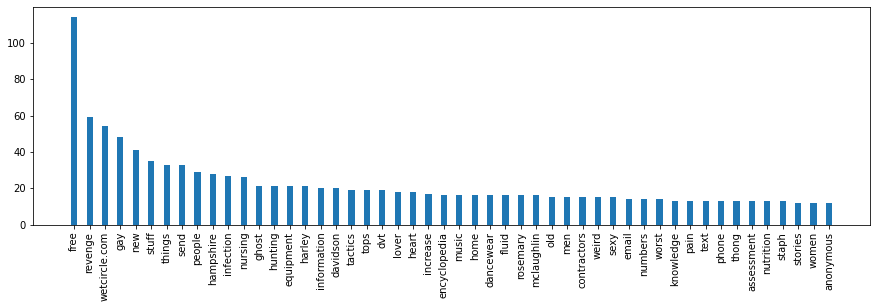

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
plt.bar(*zip(*tokenCounter.most_common(50)), width=.4)
plt.xticks(rotation=90)
plt.show()

### Histogram of lemmatized tokens

In [17]:
from collections import Counter

def tokenize_lemmatize_text(queryStream):
    for doc in nlp.pipe(queryStream, batch_size=2000, n_threads=4, disable=['ner']):
        for token in doc:
            if not token.is_stop:
                yield token.lemma_

lemmatizedCounter = Counter(tokenize_lemmatize_text(df['Query']))

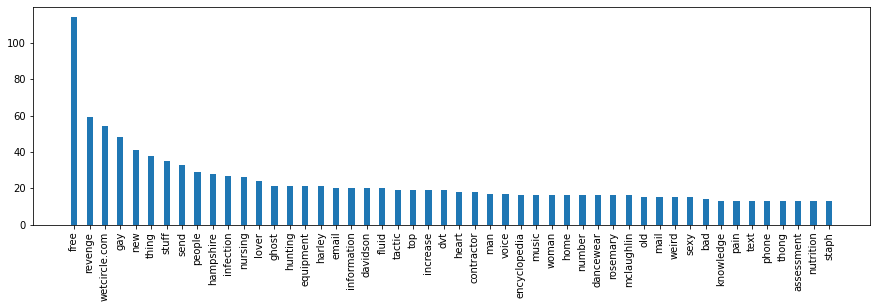

In [18]:
plt.figure(figsize=(15,4))
plt.bar(*zip(*lemmatizedCounter.most_common(50)), width=.4)
plt.xticks(rotation=90)
plt.show()

## Coparing normalized and non-normalized queries

In [19]:
def doc_to_lemmadoc(doc):
    return tokenizer(' '.join([token.lemma_ for token in doc]))

def get_docs(queryStream):
    for doc in tokenizer.pipe(queryStream, batch_size=2000):
        yield doc_to_lemmadoc(doc).similarity(doc)
        
df['sim tok v. lemm'] = list(get_docs(df['Query']))
df

,anonID,Query,QueryTime,ItemRank,ClickURL,tokenized,lemmatized,lemmatized_query,similar queries lemmatized,similar queries non-nomalized,sim tok v. lemm
1,479,family guy movie references,2006-03-03 22:37:46,1,http://www.familyguyfiles.com,"[family, guy, movie, references]","[family, guy, movie, reference]",family guy movie reference,"[(gross movie time, 0.7595110005554876), (fami...","[(family watchdog, 0.5223922064460299)]",0.969715
2,479,top grossing movies of all time,2006-03-03 22:42:42,1,http://movieweb.com,"[grossing, movies, time]","[gross, movie, time]",gross movie time,"[(family guy movie reference, 0.75951100055548...","[(the signs are all around you, 0.741497649254...",0.917912
3,479,top grossing movies of all time,2006-03-03 22:42:42,2,http://www.imdb.com,"[grossing, movies, time]","[gross, movie, time]",gross movie time,"[(family guy movie reference, 0.75951100055548...","[(the signs are all around you, 0.741497649254...",0.917912
4,479,car window decals,2006-03-03 23:24:05,9,http://www.customautotrim.com,"[car, window, decals]","[car, window, decal]",car window decal,"[(car window sponsor decal, 0.9475725029393284...","[(car window sponsor decals, 0.948068424841295...",0.974625
5,479,car window sponsor decals,2006-03-03 23:27:17,3,http://www.streetglo.net,"[car, window, sponsor, decals]","[car, window, sponsor, decal]",car window sponsor decal,"[(car window decal, 0.9475725029393284), (car ...","[(car window decals, 0.9480684248412958), (car...",0.980784
...,...,...,...,...,...,...,...,...,...,...,...
995,5179,staph infection in heart,2006-03-28 00:51:03,71,http://www.aedhelp.com,"[staph, infection, heart]","[staph, infection, heart]",staph infection heart,"[(infection, 0.9209831138143527), (assess infe...","[(infection, 0.8741297569760943), (infection a...",1.000000
996,5179,minocinsideeffects,2006-03-28 00:53:54,None,None,[minocinsideeffects],[minocinsideeffects],minocinsideeffects,[],[],1.000000
997,5179,knitting instructions,2006-03-28 15:45:02,1,http://www.learntoknit.com,"[knitting, instructions]","[knit, instruction]",knit instruction,[],[],0.772004
998,5179,time bestbuys,2006-03-30 22:52:13,None,None,"[time, bestbuys]","[time, bestbuys]",time bestbuys,"[(real - time spy, 0.7001111725566956), (gross...","[(real-time spy, 0.7001111725566956), (top gro...",1.000000
